In [1]:
# -*- coding: utf-8 -*-
import xarray as xr
import numpy as np
import numpy.ma as ma
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import glob
import calendar
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xesmf as xe
import os.path
# import dask
from datetime import datetime
np.seterr(divide='ignore', invalid='ignore')
%matplotlib inline

In [2]:
# Path to all models
path_ecearth = '/esarchive/exp/CMIP6/dcppA-hindcast/ec-earth3/cmip6-dcppA-hindcast_i1p1/DCPP/EC-Earth-Consortium/EC-Earth3/dcppA-hindcast/r2i1p1f1/SImon/siconc/gn/v20200101/'
path_norcpm1_1 = '/esarchive/exp/CMIP6/dcppA-hindcast/norcpm1/cmip6-dcppA-hindcast_i1p1/DCPP/NCC/NorCPM1/dcppA-hindcast/r2i1p1f1/SImon/siconc/gn/v20200101/'
path_norcpm1_2 = '/esarchive/exp/CMIP6/dcppA-hindcast/norcpm1/cmip6-dcppA-hindcast_i2p1/DCPP/NCC/NorCPM1/dcppA-hindcast/r2i2p1f1/SImon/siconc/gn/v20200101/'
path_canesm5 = '/esarchive/exp/CMIP6/dcppA-hindcast/canesm5/cmip6-dcppA-hindcast_i1p2/DCPP/CCCma/CanESM5/dcppA-hindcast/r2i1p2f1/SImon/siconc/gn/v20200101/'
path_ipsl = '/esarchive/exp/CMIP6/dcppA-hindcast/ipsl-cm6a-lr/cmip6-dcppA-hindcast_i1p1/DCPP/IPSL/IPSL-CM6A-LR/dcppA-hindcast/r2i1p1f1/SImon/siconc/gn/v20200101/'
path_miroc = '/esarchive/exp/CMIP6/dcppA-hindcast/miroc6/cmip6-dcppA-hindcast_i1p1/DCPP/MIROC/MIROC6/dcppA-hindcast/r2i1p1f1/SImon/siconc/gn/v20200101/'
path_mpi = '/esarchive/exp/CMIP6/dcppA-hindcast/mpi-esm1-2-hr/cmip6-dcppA-hindcast_i1p1/DCPP/MPI-M/MPI-ESM1-2-HR/dcppA-hindcast/r2i1p1f1/SImon/siconc/gn/v20200101/'

In [3]:
# SET OPTIONS #

# Dictionary with model names and consortiums for paths
model_dic = {'ecearth': ['ec-earth3', 'i2p1', 'EC-Earth-Consortium/EC-Earth3', 'EC-Earth3'], 'norcpm1_1': ['norcpm1', 'i1p1', 'NCC/NorCPM1'],
             'norcpm1_2': ['norcpm1', 'i2p1', 'NCC/NorCPM1'], 'canesm': ['canesm5', 'i1p2', 'CCCma/CanESM5'],
             'ipsl-cm': ['ipsl-cm6a-lr', 'i1p1', 'IPSL/IPSL-CM6A-LR'], 'miroc': ['miroc6', 'i1p1', 'MIROC/MIROC6'],
             'mpi': ['mpi-esm1-2-hr', 'i1p1', 'MPI-M/MPI-ESM1-2-HR']}

path1 = '/esarchive/exp/CMIP6/dcppA-hindcast/'
path2 = 'cmip6-dcppA-hindcast_' 
path3 = 'dcppA-hindcast'
compo = 'SImon'
mod_compo = 'seaIce'
vdate = 'v20200101/'
var = 'siconc'
pathout = '/esarchive/scratch/ruben/dcpp/data/'

# Members EC-Earth
mem_pred1_ecearth = 6
mem_pred2_ecearth = 10
members_pred_ecearth = []
for r in range(mem_pred1_ecearth, mem_pred2_ecearth+1):
    me_pred_ecearth = 'r{0}i2p1f1'.format(r)
    members_pred_ecearth.append(me_pred_ecearth)

year1 = 1961
year2 = 2000
# Chunks EC-Earth
chunks_pred_ecearth = []
for j in range(year1, year2+1):
    chupred = '{0}01-{1}12'.format(str(j), str(j))
    chunks_pred_ecearth.append(chupred)
    
print(chunks_pred_ecearth)

# Chunks HadiSST
chunks_hadisst = []
for j in range(year1, year2+1):
    for t in range(1, 13):
        chu_disst = '{0}{1}'.format(str(j), str(t).zfill(2))
        chunks_hadisst.append(chu_disst)

#print(chunks_hadisst)  

['196101-196112', '196201-196212', '196301-196312', '196401-196412', '196501-196512', '196601-196612', '196701-196712', '196801-196812', '196901-196912', '197001-197012', '197101-197112', '197201-197212', '197301-197312', '197401-197412', '197501-197512', '197601-197612', '197701-197712', '197801-197812', '197901-197912', '198001-198012', '198101-198112', '198201-198212', '198301-198312', '198401-198412', '198501-198512', '198601-198612', '198701-198712', '198801-198812', '198901-198912', '199001-199012', '199101-199112', '199201-199212', '199301-199312', '199401-199412', '199501-199512', '199601-199612', '199701-199712', '199801-199812', '199901-199912', '200001-200012']


In [4]:
# Load HadISST # (Continous Timeseries)
hadisst_path = '/esarchive/obs/ukmo/hadisst_v2.2/monthly_mean/sic/'

filenames_hadisst = []
for chu in chunks_hadisst:
    filename_ = glob.glob(hadisst_path + 'sic_' + chu + '.nc')
    filenames_hadisst.append(filename_[0])
    
list_hadisst = []
for file_ in filenames_hadisst:
    date_hadisst = file_.split('sic_')[1].split('.')[0]
    
    ds = xr.open_dataset(file_, decode_times=False)
    mon_index = xr.cftime_range(date_hadisst, periods=1, freq='MS')
    ds.coords['time'] = mon_index
    list_hadisst.append(ds)
    
ds_hadisst = xr.concat(list_hadisst, dim='time')
ds_hadisst = ds_hadisst.sortby('time') # 124 Mb

In [5]:
# Histo2Hindcast #
ds_hadisst2 = ds_hadisst['sic']*100 #.to_array()

formatted_hadisst = []
for s_dates in range(0, len(chunks_pred_ecearth)):
    forecast_period = chunks_pred_ecearth[s_dates]
    first_step = forecast_period.split('-')[0]
    last_step = forecast_period.split('-')[1]
    start_slice = '-'.join([first_step[:4], first_step[-2:]])
    end_slice = '-'.join([last_step[:4], last_step[-2:]])
    sele = ds_hadisst2.sel(time=slice(start_slice, end_slice))
    sele['time'] = np.arange(1, 13) # ftime
    formatted_hadisst.append(sele)
    
sdates_dim_hadisst = xr.DataArray(chunks_pred_ecearth, name='sdate', dims='sdate')
reshaped_hadisst = xr.concat(formatted_hadisst, dim=sdates_dim_hadisst)

In [6]:
# Load EC-Earth # 1st year

path_saving_ecearth = '{0}{1}_pred_ecearth_mean_{2}-{3}_ensemble_year1.nc'.format(pathout, var, str(year1), str(year2))

if os.path.isfile(path_saving_ecearth):
    print('File exists. Loading... ') # 40x12x292x362
    ecearth_ensemble = xr.open_dataarray(path_saving_ecearth, decode_times=False)
else:
    print('IT DOES NOT EXIST') # Load everything
    HIND_ecearth = []
    for mem in members_pred_ecearth:
        filenames_pred = []
        for chu in chunks_pred_ecearth:

            start_date = int(chu.split('01')[0]) - 1

            file_path_pred = '{0}{1}/{2}{3}{4}{5}/{6}/{7}/{8}/{9}/gn/{10}'.format(path1, model_dic['ecearth'][0], path2,                     
                                                                                model_dic['ecearth'][1], '/DCPP/',
                                                                                model_dic['ecearth'][2], path3, mem, compo, 
                                                                                var, vdate)

            filename_ = glob.glob(file_path_pred + var + '_' + compo + '_' + model_dic['ecearth'][3] + '_' + path3 + '_s' +
                                  str(start_date) + '-' + mem + '_gn_' + chu + '.nc')        

            filenames_pred.append(filename_[0])

        f_list_pred = sorted(filenames_pred)

        list_pred = []
        for file_ in f_list_pred:
            ds = xr.open_dataset(file_, decode_times=False, chunks={'time': 1})
            ds['time'] = np.arange(1, 13) # forecast time 1st year
            list_pred.append(ds)

        da_num_pred = xr.DataArray(chunks_pred_ecearth, name='sdate', dims='sdate')
        ds_pred_num = xr.concat(list_pred, dim=da_num_pred)

        HIND_ecearth.append(ds_pred_num)

    hindcast = xr.DataArray(members_pred_ecearth, name='member', dims='member')
    ds_hind = xr.concat(HIND_ecearth, dim=hindcast)
    # Ensemble Mean and Start Date Mean
    ecearth_ensemble = ds_hind[var].mean(dim='member')
    del ds_hind

    # print('Size of the file: ', pred_clim.nbytes/1e6, 'Mb')
    
    ecearth_ensemble.to_netcdf(path = path_saving_ecearth, format = 'NETCDF4')

File exists. Loading... 


In [7]:
# Anomaly Calculation #
#######################
# ~ HadiSST
sd_mean_hadisst = reshaped_hadisst.groupby('time').mean(dim='sdate') # , skipna=True, keep_attrs = True)
ano_hadisst = reshaped_hadisst.groupby('time') - sd_mean_hadisst

# ~ EC-Earth
sd_mean_ecearth = ecearth_ensemble.groupby('time').mean(dim='sdate', keep_attrs = True)
ano_ecearth = ecearth_ensemble.groupby('time') - sd_mean_ecearth
#ano_ecearth[1,1,:,:].plot()

# Calculate correlations (When I have HadiSST anomalies)
# sst_cor = corrrelation(sst_anom, sst_ref, dims='time')
# pc = sst_cor.plot()

/shared/earth/software/xarray/0.13.0-foss-2015a-Python-3.7.3/lib/python3.7/site-packages/xarray-0.13.0-py3.7.egg/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/shared/earth/software/xarray/0.13.0-foss-2015a-Python-3.7.3/lib/python3.7/site-packages/xarray-0.13.0-py3.7.egg/xarray/core/common.py:608: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  self, group, squeeze=squeeze, restore_coord_dims=restore_coord_dims
/shared/earth/software/xarray/0.13.0-foss-2015a-Python-3.7.3/lib/python3.7/site-packages/xarray-0.13.0-py3.7.egg/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [59]:
latitude = ano_ecearth.latitude
latitude

<xarray.DataArray 'latitude' (j: 292, i: 362)>
array([[-78.39350128, -78.39350128, -78.39350128, ..., -78.39350128,
        -78.39350128, -78.39350128],
       [-78.19058228, -78.19058228, -78.19058228, ..., -78.19058228,
        -78.19058228, -78.19058228],
       [-77.98416901, -77.98416901, -77.98416901, ..., -77.98416901,
        -77.98416901, -77.98416901],
       ...,
       [ 50.00502014,  50.00502014,  50.22440338, ...,  50.22440338,
         50.00502014,  50.00502014],
       [ 50.01094055,  50.01094055,  50.22936249, ...,  50.22936249,
         50.01094055,  50.01094055],
       [ 50.01094055,  50.01094055,  50.22936249, ...,  50.22936249,
         50.01094055,  50.01094055]])
Coordinates:
    latitude   (j, i) float64 -78.39 -78.39 -78.39 -78.39 ... 50.23 50.01 50.01
    type       |S7 ...
    longitude  (j, i) float64 72.5 73.5 74.5 75.5 ... 73.05 73.04 73.0 72.99
  * j          (j) int32 1 2 3 4 5 6 7 8 9 ... 285 286 287 288 289 290 291 292
  * i          (i) int32 1 2 3 4

In [8]:
# Interpolate Model Anomalies to regular # ~~~~~~

latitude = ano_ecearth.latitude
longitude = ano_ecearth.longitude

res_new = 1 # degrees; the resolution of the new grid
lat_new = -90 + np.arange((2*90)/res_new) 
lon_new = np.arange((360)/res_new) 
lon_new, lat_new = np.meshgrid(lon_new,lat_new)

#data = np.squeeze(np.array(first_month))
data_new = np.empty(shape=(40,12,180,360))

for sdate in range(0, 40):
    for mon in range(0, 12):
        
        data = np.squeeze(np.array(ano_ecearth[sdate,mon,:,:]))
        ndim0 = np.size(data,axis=0)
        ndim1 = np.size(data,axis=1)

        # Regrid
      #  data_new = data
        lat_temp = latitude.copy()
        lon_temp = longitude.copy()
        method = np.str('nearest_s2d')

        # Make sure the dimensions of the new grid are in the right order
        lat_temp = lat_new.copy()
        lon_temp = lon_new.copy()
        if ndim0>ndim1:
            lat_temp = np.transpose(lat_temp)
            lon_temp = np.transpose(lon_temp)

        lat_temp2 = latitude.copy()
        lon_temp2 = longitude.copy()

        # Create the xarray datasets to feed into the xesmf regridder
        ds_in = xr.Dataset({'lat': (['x','y'],lat_temp2),
                            'lon': (['x','y'],lon_temp2)})
        ds_out = xr.Dataset({'lat': (['x','y'],lat_temp),
                                'lon': (['x','y'],lon_temp)})
        # Regrid the data
        f = xe.Regridder(ds_in, ds_out, method, periodic=True, reuse_weights=True)
        data_new[sdate,mon,:,:] = f(data)

Reuse existing file: nearest_s2d_292x362_180x360_peri.nc
Reuse existing file: nearest_s2d_292x362_180x360_peri.nc
Reuse existing file: nearest_s2d_292x362_180x360_peri.nc
Reuse existing file: nearest_s2d_292x362_180x360_peri.nc
Reuse existing file: nearest_s2d_292x362_180x360_peri.nc
Reuse existing file: nearest_s2d_292x362_180x360_peri.nc
Reuse existing file: nearest_s2d_292x362_180x360_peri.nc
Reuse existing file: nearest_s2d_292x362_180x360_peri.nc
Reuse existing file: nearest_s2d_292x362_180x360_peri.nc
Reuse existing file: nearest_s2d_292x362_180x360_peri.nc
Reuse existing file: nearest_s2d_292x362_180x360_peri.nc
Reuse existing file: nearest_s2d_292x362_180x360_peri.nc
Reuse existing file: nearest_s2d_292x362_180x360_peri.nc
Reuse existing file: nearest_s2d_292x362_180x360_peri.nc
Reuse existing file: nearest_s2d_292x362_180x360_peri.nc
Reuse existing file: nearest_s2d_292x362_180x360_peri.nc
Reuse existing file: nearest_s2d_292x362_180x360_peri.nc
Reuse existing file: nearest_s2

In [58]:
#np.isnan(ano_hadisst).any()
#ano_ec = np.nan_to_num(data_new) # Convert NaN to Zero
#ano_had = np.nan_to_num(ano_hadisst)
#np.isnan(ano_had).any()
ano_ecearth[8,10,2, :]
data_new[8,10,2,:]

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, na

In [24]:
#sd_mean_hadisst = reshaped_hadisst.groupby('time').mean(dim='sdate') # , skipna=True, keep_attrs = True)
#ano_hadisst = reshaped_hadisst.groupby('time') - sd_mean_hadisst

(40, 12, 180, 360)

In [40]:
import scipy.stats
corr = scipy.stats.pearsonr(np.squeeze(ano_ec[:,0,1,100]), np.squeeze(ano_had[:,0,1,100]))

# Hay que poner NaN donde uno de los 2 tenga NaN


In [51]:
ano_hadisst[1,4,2,:]
#data_new[1,4,2,:]

<xarray.DataArray 'sic' (longitude: 360)>
array([ 0.08203888,  0.0797348 ,  0.07759094,  0.16822052,  0.16664886,
        0.16020966,  0.15881348,  0.1576004 ,  0.14897919,  0.1478424 ,
        0.13915253,  0.1380539 ,  0.13694763,  0.13561249,  0.13425446,
        0.22547913,  0.22437286,  0.22346497,  0.2226181 ,  0.21408844,
        0.21305847,  0.21211243,  0.21137238,  0.21121216,  0.21138763,
        0.21163177,  0.2063675 ,  0.2063675 ,  0.20648956,  0.2068634 ,
        0.20750427,  0.20827484,  0.20877838,  0.21176147,  0.21037292,
        0.213974  ,  0.22000122,  0.22062683,  0.28671265,  0.28513336,
        0.27563477,  0.27433014,  0.27314758,  0.27178955,  0.27035522,
        0.27742004,  0.27694702,  0.27664948,  0.27654266,  0.2769165 ,
        0.27765656,  0.27697754,  0.2797165 ,  0.28071594,  0.28079987,
        0.28190613,  0.28273773,  0.28354645,  0.2844696 ,  0.27854156,
        0.280159  ,  0.28121948,  0.2813034 ,  0.27829742,  0.27534485,
        0.27270508,  0

Reuse existing file: nearest_s2d_292x362_180x360_peri.nc
Reuse existing file: nearest_s2d_384x320_360x180_peri.nc


/shared/earth/software/xesmf/0.2.1-foss-2015a-Python-3.7.3/lib/python3.7/site-packages/xesmf/backend.py:36: UserWarning: Input array is not F_CONTIGUOUS. Will affect performance.
  warnings.warn("Input array is not F_CONTIGUOUS. "


Reuse existing file: nearest_s2d_384x320_360x180_peri.nc
Reuse existing file: nearest_s2d_291x360_180x360_peri.nc
Reuse existing file: nearest_s2d_332x362_180x360_peri.nc
Reuse existing file: nearest_s2d_256x360_180x360_peri.nc
Reuse existing file: nearest_s2d_404x802_180x360_peri.nc
Reuse existing file: nearest_s2d_304x448_180x360_peri.nc


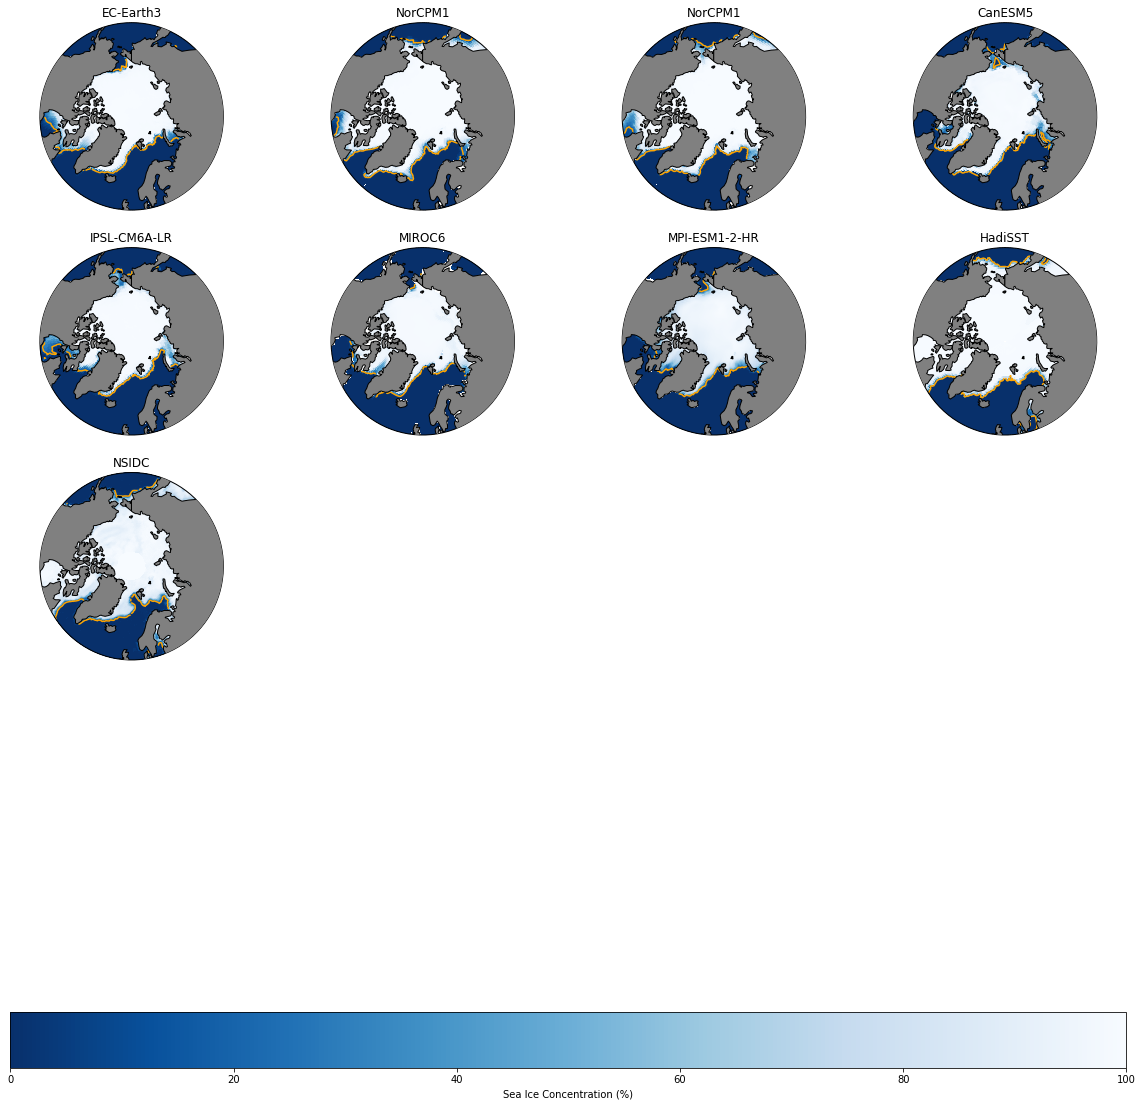

In [43]:
# ARCTIC # (Plot Models and Observations)
#~~~~~~~~#
# fig1 = plt.figure(figsize=(20,20))
fig1, axes = plt.subplots(figsize=(20,20), constrained_layout=False) #, sharex=True, sharey=True)

i = 1
index = 0
for m in mod_to_plot:
    index += 1
    axes.set_axis_off()

    # Select VAR and
    # Deal with diferent names for latitude and longitude coordinates
    if m == 'hadisst':
        sic_model = dic_mod[m]['sic']*100
        latitude = sic_model.latitude
        longitude = sic_model.longitude
        first_month = sic_model
    else:
        sic_model = dic_mod[m]['siconc']
        if m == 'nsidc':
            first_month = sic_model
            latitude = sic_model.latitude
            longitude = sic_model.longitude
        else:
            first_month = sic_model.sel(time='1962-11-16')
            if np.str(dic_mod[m].source_id) == 'IPSL-CM6A-LR':
                latitude = sic_model.nav_lat
                longitude = sic_model.nav_lon
            else:
                latitude = sic_model.latitude
                longitude = sic_model.longitude
    
    # New evenly spaced, monotonically increasing lat-lon grid for regridding the sea ice
    # concentration for the contour plot (otherwise the contour will reverse on itself)
    res_new = 1 # degrees; the resolution of the new grid
    lat_new = -90 + np.arange((2*90)/res_new) # 1+(2*90)

    lon_new = np.arange((360)/res_new) # 1 +(360
    lon_new, lat_new = np.meshgrid(lon_new,lat_new)

    ice_edge_conc = 15 # the concentration threshold for the sea ice edge

    # Load in the sea ice concentration for the months I want,
    # average it over those months, and find its size
    
    data = np.squeeze(np.array(first_month))
    ndim0 = np.size(data,axis=0)
    ndim1 = np.size(data,axis=1)
    
    if m is not 'hadisst':
        # Regrid
        data_new = data
        lat_temp = latitude.copy()
        lon_temp = longitude.copy()
        method = np.str('bilinear')
        method = np.str('nearest_s2d')

        # Make sure the dimensions of the new grid are in the right order
        lat_temp = lat_new.copy()
        lon_temp = lon_new.copy()
        if ndim0>ndim1:
            lat_temp = np.transpose(lat_temp)
            lon_temp = np.transpose(lon_temp)

        lat_temp2 = latitude.copy()
        lon_temp2 = longitude.copy()
        # lat_temp2[np.abs(lat_temp2)>90] = np.nan
        # lon_temp2[np.abs(lon_temp2)>360] = np.nan #-- > ERROR because it is not a list

        # Create the xarray datasets to feed into the xesmf regridder
        ds_in = xr.Dataset({'lat': (['x','y'],lat_temp2),
                            'lon': (['x','y'],lon_temp2)})
        ds_out = xr.Dataset({'lat': (['x','y'],lat_temp),
                                'lon': (['x','y'],lon_temp)})
        # Regrid the data
        f = xe.Regridder(ds_in, ds_out, method, periodic=True, reuse_weights=True)
        data_new = f(data)

        # A data mask for NortPolarStereo plots
        mydata = ma.masked_where(latitude<0.,data.copy())
        mydata_new = ma.masked_where(lat_temp<0.,data_new.copy())
    elif m == 'hadisst':
        lon_temp = longitude
        lat_temp = latitude
        mydata = data.copy()
        mydata_new = data.copy()
        
    # Compute a circle in axes coordinates, which we can use as a boundary
    # for the map. We can pan/zoom as much as we like - the boundary will be
    # permanently circular.
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    # Make a pcolor plot of sea ice concentration, and contour the sea ice edge
    ax = fig1.add_subplot(5, 4, index, projection = ccrs.NorthPolarStereo()) # 5, 4
    ax.add_feature(cfeature.LAND,zorder=100,edgecolor='black',facecolor='Grey')
    ax.set_boundary(circle, transform=ax.transAxes)
    ax.set_extent([-180, 180, 55, 90], crs=ccrs.PlateCarree())
    # ax.set_extent([0.005, 360, -90, -50], crs=ccrs.PlateCarree()) # South Pole
    this = ax.pcolormesh(longitude,latitude,mydata,transform=ccrs.PlateCarree(),cmap = plt.cm.Blues_r, vmin=0, vmax=100)
    this2 = ax.contour(lon_temp,lat_temp,mydata_new,[ice_edge_conc],transform=ccrs.PlateCarree(),colors='orange')
    if m == 'nsidc':
        plt.title('NSIDC')
    elif m == 'hadisst':
        plt.title('HadiSST')
    else:
        plt.title(np.str(dic_mod[m].source_id))
    
fig1.colorbar(this, ax=axes, orientation='horizontal', fraction = 0.09, label = 'Sea Ice Concentration (%)')#, shrink=-0.6)
# plt.show()
# plt.savefig('example.png')

In [22]:
#ano_ecearth.dims

('sdate', 'time', 'j', 'i')

## Open DataSets (Specific time steps for visualizing SIC)

In [32]:
# EC-EARTH #
sic_ecearth = xr.open_dataset(path_ecearth + 'siconc_SImon_EC-Earth3_dcppA-hindcast_s1962-r2i1p1f1_gn_196211-196310.nc')
print('Size of the file: ', sic_ecearth.nbytes/1e6, 'Mb')

Size of the file:  9.304863 Mb


In [33]:
# NORCPM1_1 #
sic_norcpm1_1 = xr.open_dataset(path_norcpm1_1 + 'siconc_SImon_NorCPM1_dcppA-hindcast_s1962-r2i1p1f1_gn_196210-197212.nc')

In [34]:
# NORCPM1_2 #
sic_norcpm1_2 = xr.open_dataset(path_norcpm1_2 + 'siconc_SImon_NorCPM1_dcppA-hindcast_s1962-r2i2p1f1_gn_196210-197212.nc')

In [35]:
# CanESM5 #
sic_canesm5 = xr.open_dataset(path_canesm5 + 'siconc_SImon_CanESM5_dcppA-hindcast_s1961-r2i1p2f1_gn_196201-197112.nc')

In [36]:
# IPSL-CM6 #
sic_ipsl = xr.open_dataset(path_ipsl + 'siconc_SImon_IPSL-CM6A-LR_dcppA-hindcast_s1961-r2i1p1f1_gn_196201-197112.nc')

In [38]:
# MIROC6 # 
sic_miroc = xr.open_dataset(path_miroc + 'siconc_SImon_MIROC6_dcppA-hindcast_s1962-r2i1p1f1_gn_196211-197212.nc')

In [39]:
# MPI-ESM1 #
sic_mpi = xr.open_dataset(path_mpi + 'siconc_SImon_MPI-ESM1-2-HR_dcppA-hindcast_s1962-r2i1p1f1_gn_196211-197212.nc')

In [40]:
# NSIDC 0051 monthly data #
dfile = '/esarchive/obs/nasa/nsidc0051_gsfc_nasateam_seaice/processed/north/monthly_mean/siconc_r1i1p1_mon_197901_nh-psn25.nc'
sic_nsidc = xr.open_dataset(dfile)

In [6]:
# HADISST #
hadisst_path = '/esarchive/obs/ukmo/hadisst_v2.2/monthly_mean/sic/'
sic_hadisst = xr.open_dataset(hadisst_path + 'sic_196101.nc')

In [41]:
# SELECT DATA TO BE PLOTTED
dic_mod = {'ecearth': sic_ecearth, 'norcpm1_1': sic_norcpm1_1,
             'norcpm1_2': sic_norcpm1_2, 'canesm': sic_canesm5,
             'ipsl-cm': sic_ipsl, 'miroc': sic_miroc,
             'mpi': sic_mpi, 'hadisst': sic_hadisst, 'nsidc': sic_nsidc}
mod_to_plot = ['ecearth', 'norcpm1_1', 'norcpm1_2', 'canesm', 'ipsl-cm', 'miroc', 'mpi', 'hadisst', 'nsidc']

Reuse existing file: nearest_s2d_292x362_180x360_peri.nc
Reuse existing file: nearest_s2d_384x320_360x180_peri.nc


/shared/earth/software/xesmf/0.2.1-foss-2015a-Python-3.7.3/lib/python3.7/site-packages/xesmf/backend.py:36: UserWarning: Input array is not F_CONTIGUOUS. Will affect performance.
  warnings.warn("Input array is not F_CONTIGUOUS. "


Reuse existing file: nearest_s2d_384x320_360x180_peri.nc
Reuse existing file: nearest_s2d_291x360_180x360_peri.nc
Reuse existing file: nearest_s2d_332x362_180x360_peri.nc
Reuse existing file: nearest_s2d_256x360_180x360_peri.nc
Reuse existing file: nearest_s2d_404x802_180x360_peri.nc
Reuse existing file: nearest_s2d_304x448_180x360_peri.nc


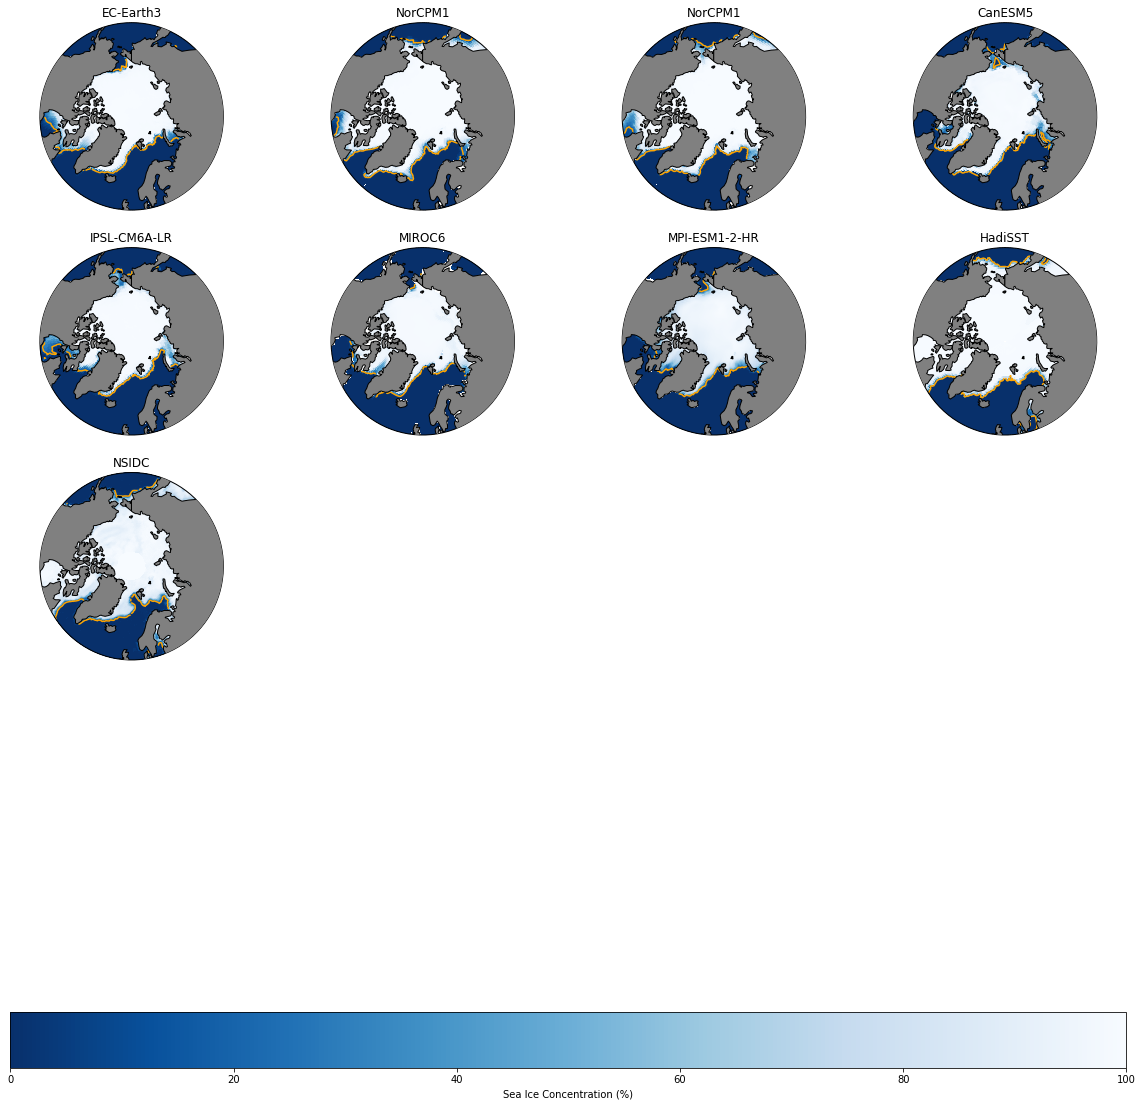

In [43]:
# ARCTIC # (Plot Models and Observations)
#~~~~~~~~#
# fig1 = plt.figure(figsize=(20,20))
fig1, axes = plt.subplots(figsize=(20,20), constrained_layout=False) #, sharex=True, sharey=True)

i = 1
index = 0
for m in mod_to_plot:
    index += 1
    axes.set_axis_off()

    # Select VAR and
    # Deal with diferent names for latitude and longitude coordinates
    if m == 'hadisst':
        sic_model = dic_mod[m]['sic']*100
        latitude = sic_model.latitude
        longitude = sic_model.longitude
        first_month = sic_model
    else:
        sic_model = dic_mod[m]['siconc']
        if m == 'nsidc':
            first_month = sic_model
            latitude = sic_model.latitude
            longitude = sic_model.longitude
        else:
            first_month = sic_model.sel(time='1962-11-16')
            if np.str(dic_mod[m].source_id) == 'IPSL-CM6A-LR':
                latitude = sic_model.nav_lat
                longitude = sic_model.nav_lon
            else:
                latitude = sic_model.latitude
                longitude = sic_model.longitude
    
    # New evenly spaced, monotonically increasing lat-lon grid for regridding the sea ice
    # concentration for the contour plot (otherwise the contour will reverse on itself)
    res_new = 1 # degrees; the resolution of the new grid
    lat_new = -90 + np.arange((2*90)/res_new) # 1+(2*90)

    lon_new = np.arange((360)/res_new) # 1 +(360
    lon_new, lat_new = np.meshgrid(lon_new,lat_new)

    ice_edge_conc = 15 # the concentration threshold for the sea ice edge

    # Load in the sea ice concentration for the months I want,
    # average it over those months, and find its size
    
    data = np.squeeze(np.array(first_month))
    ndim0 = np.size(data,axis=0)
    ndim1 = np.size(data,axis=1)
    
    if m is not 'hadisst':
        # Regrid
        data_new = data
        lat_temp = latitude.copy()
        lon_temp = longitude.copy()
        method = np.str('bilinear')
        method = np.str('nearest_s2d')

        # Make sure the dimensions of the new grid are in the right order
        lat_temp = lat_new.copy()
        lon_temp = lon_new.copy()
        if ndim0>ndim1:
            lat_temp = np.transpose(lat_temp)
            lon_temp = np.transpose(lon_temp)

        lat_temp2 = latitude.copy()
        lon_temp2 = longitude.copy()
        # lat_temp2[np.abs(lat_temp2)>90] = np.nan
        # lon_temp2[np.abs(lon_temp2)>360] = np.nan #-- > ERROR because it is not a list

        # Create the xarray datasets to feed into the xesmf regridder
        ds_in = xr.Dataset({'lat': (['x','y'],lat_temp2),
                            'lon': (['x','y'],lon_temp2)})
        ds_out = xr.Dataset({'lat': (['x','y'],lat_temp),
                                'lon': (['x','y'],lon_temp)})
        # Regrid the data
        f = xe.Regridder(ds_in, ds_out, method, periodic=True, reuse_weights=True)
        data_new = f(data)

        # A data mask for NortPolarStereo plots
        mydata = ma.masked_where(latitude<0.,data.copy())
        mydata_new = ma.masked_where(lat_temp<0.,data_new.copy())
    elif m == 'hadisst':
        lon_temp = longitude
        lat_temp = latitude
        mydata = data.copy()
        mydata_new = data.copy()
        
    # Compute a circle in axes coordinates, which we can use as a boundary
    # for the map. We can pan/zoom as much as we like - the boundary will be
    # permanently circular.
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    # Make a pcolor plot of sea ice concentration, and contour the sea ice edge
    ax = fig1.add_subplot(5, 4, index, projection = ccrs.NorthPolarStereo()) # 5, 4
    ax.add_feature(cfeature.LAND,zorder=100,edgecolor='black',facecolor='Grey')
    ax.set_boundary(circle, transform=ax.transAxes)
    ax.set_extent([-180, 180, 55, 90], crs=ccrs.PlateCarree())
    # ax.set_extent([0.005, 360, -90, -50], crs=ccrs.PlateCarree()) # South Pole
    this = ax.pcolormesh(longitude,latitude,mydata,transform=ccrs.PlateCarree(),cmap = plt.cm.Blues_r, vmin=0, vmax=100)
    this2 = ax.contour(lon_temp,lat_temp,mydata_new,[ice_edge_conc],transform=ccrs.PlateCarree(),colors='orange')
    if m == 'nsidc':
        plt.title('NSIDC')
    elif m == 'hadisst':
        plt.title('HadiSST')
    else:
        plt.title(np.str(dic_mod[m].source_id))
    
fig1.colorbar(this, ax=axes, orientation='horizontal', fraction = 0.09, label = 'Sea Ice Concentration (%)')#, shrink=-0.6)
# plt.show()
# plt.savefig('example.png')

In [101]:
all_models

[<xarray.Dataset>
 Dimensions:    (latitude: 180, longitude: 360, time: 1, x: 2)
 Coordinates:
   * longitude  (longitude) float32 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
   * latitude   (latitude) float32 89.5 88.5 87.5 86.5 ... -87.5 -88.5 -89.5
   * time       (time) datetime64[ns] 1961-01-16T12:00:00
 Dimensions without coordinates: x
 Data variables:
     time_bnds  (time, x) float32 ...
     sic        (time, latitude, longitude) float32 0.999 0.996 0.996 ... nan nan
 Attributes:
     CDI:                        Climate Data Interface version 1.6.3 (http://...
     Conventions:                CF-1.0
     history:                    Wed Jun 22 17:39:14 2016: cdo splitmon sic_19...
     source:                     Met Office
     Title:                      Monthly 1 degree version of HadISST.2.2.0.0
     reference:                  update of Titchner and Rayner 2015 DOI: 10.10...
     supplementary_information:  contact holly.titchner@metoffice.gov.uk or jo...
     CDO:       

In [ ]:
# BACK-UP
# # ARCTIC # 
# #~~~~~~~~#
# # fig1 = plt.figure(figsize=(20,20))
# fig1, axes = plt.subplots(figsize=(20,20), constrained_layout=False) #, sharex=True, sharey=True)

# i = 1
# index = 0
# for m in all_models:
#     index += 1
#     axes.set_axis_off()

#     # Select VAR
#     try:
#         m = sic_hadisst
#         sic_model = m['sic']
#     except:
#         print('No HadISST')
#     else:
#         sic_model = m['siconc']

#     # Deal with diferent names for latitude and longitude coordinates
# #     try:
# #         sic_nsidc
# #     except NameError:
# #       print("NOT NSIDC!")
# #     else:
# #       print("Variable is defined.")
#     try:
#         np.str(m.source_id) == 'IPSL-CM6A-LR'
#         latitude = sic_model.nav_lat
#         longitude = sic_model.nav_lon
#     except:
#         latitude = sic_model.latitude
#         longitude = sic_model.longitude
#         print('hola')
    
# #     if np.str(m.source_id) == 'IPSL-CM6A-LR': # if m is not sic_nsidc and np.str(m.source_id) == 'IPSL-CM6A-LR': 
# #         latitude = sic_model.nav_lat
# #         longitude = sic_model.nav_lon
# #     else:
# #         latitude = sic_model.latitude
# #         longitude = sic_model.longitude

#     # Select MONTH
# #     if m is sic_hadisst: # sic_nsidc
# #         first_month = sic_model
# #     else:
# #         first_month = sic_model.sel(time='1962-11-16')
#     try: 
#         m = sic_hadisst
#         first_month = sic_model
#     except:
#         first_month = sic_model.sel(time='1962-11-16')

    
#     # New evenly spaced, monotonically increasing lat-lon grid for regridding the sea ice
#     # concentration for the contour plot (otherwise the contour will reverse on itself)
#     res_new = 1 # degrees; the resolution of the new grid
#     lat_new = -90 + np.arange(1+(2*90)/res_new) # only go from 80S to 80N

#     lon_new = np.arange(1+(360)/res_new)
#     lon_new, lat_new = np.meshgrid(lon_new,lat_new)

#     ice_edge_conc = 15 # the concentration threshold for the sea ice edge

#     # Load in the sea ice concentration for the months I want,
#     # average it over those months, and find its size
    
#     data = np.squeeze(np.array(first_month))
#     ndim0 = np.size(data,axis=0)
#     ndim1 = np.size(data,axis=1)

#     # Regrid
#     data_new = data
#     lat_temp = latitude.copy()
#     lon_temp = longitude.copy()
#     method = np.str('bilinear')
#     method = np.str('nearest_s2d')

#     # Make sure the dimensions of the new grid are in the right order
#     lat_temp = lat_new.copy()
#     lon_temp = lon_new.copy()
#     if ndim0>ndim1:
#         lat_temp = np.transpose(lat_temp)
#         lon_temp = np.transpose(lon_temp)

#     lat_temp2 = latitude.copy()
#     lon_temp2 = longitude.copy()
#     # lat_temp2[np.abs(lat_temp2)>90] = np.nan
#     # lon_temp2[np.abs(lon_temp2)>360] = np.nan #-- > ERROR because it is not a list

#     # Create the xarray datasets to feed into the xesmf regridder
#     ds_in = xr.Dataset({'lat': (['x','y'],lat_temp2),
#                         'lon': (['x','y'],lon_temp2)})
#     ds_out = xr.Dataset({'lat': (['x','y'],lat_temp),
#                             'lon': (['x','y'],lon_temp)})

#     # Regrid the data
#     f = xe.Regridder(ds_in, ds_out, method, periodic=True, reuse_weights=True)
#     data_new = f(data)

#     # A data mask for SouthPolarStereo plots
#     # mydata = ma.masked_where(latitude>0.,data.copy())
#     # mydata_new = ma.masked_where(lat_temp>0.,data_new.copy())

#     # A data mask for NortPolarStereo plots
#     mydata = ma.masked_where(latitude<0.,data.copy())
#     mydata_new = ma.masked_where(lat_temp<0.,data_new.copy())

#     # Compute a circle in axes coordinates, which we can use as a boundary
#     # for the map. We can pan/zoom as much as we like - the boundary will be
#     # permanently circular.
#     theta = np.linspace(0, 2*np.pi, 100)
#     center, radius = [0.5, 0.5], 0.5
#     verts = np.vstack([np.sin(theta), np.cos(theta)]).T
#     circle = mpath.Path(verts * radius + center)
        
#     # Make a pcolor plot of sea ice concentration, and contour the sea ice edge
#     ax = fig1.add_subplot(2, 4, index, projection = ccrs.NorthPolarStereo()) # 5, 4
#     ax.add_feature(cfeature.LAND,zorder=100,edgecolor='black',facecolor='Grey')
#     ax.set_boundary(circle, transform=ax.transAxes)
#     ax.set_extent([-180, 180, 55, 90], crs=ccrs.PlateCarree())
#     # ax.set_extent([0.005, 360, -90, -50], crs=ccrs.PlateCarree()) # South Pole
#     this = ax.pcolormesh(longitude,latitude,mydata,transform=ccrs.PlateCarree(),cmap = plt.cm.Blues_r, vmin=0, vmax=100)
#     this2 = ax.contour(lon_temp,lat_temp,mydata_new,[ice_edge_conc],transform=ccrs.PlateCarree(),colors='orange')
#     if m is sic_nsidc:
#         plt.title('NSIDC')    
#     else:
#         plt.title(np.str(m.source_id))
    
# fig1.colorbar(this, ax=axes, orientation='horizontal', fraction = 0.09, label = 'Sea Ice Concentration (%)')#, shrink=-0.6)
# # plt.show()
# # plt.savefig('example.png')